In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product


# basic number of currencies we will be working with
x = 10

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('crypto-markets.csv')
df.head(x)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32
5,bitcoin,BTC,Bitcoin,2013-05-03,1,106.25,108.13,79.10,97.75,0,1180070000,0.6424,29.03
6,bitcoin,BTC,Bitcoin,2013-05-04,1,98.10,115.00,92.50,112.50,0,1089890000,0.8889,22.50
7,bitcoin,BTC,Bitcoin,2013-05-05,1,112.90,118.80,107.14,115.91,0,1254760000,0.7521,11.66
8,bitcoin,BTC,Bitcoin,2013-05-06,1,115.98,124.66,106.64,112.30,0,1289470000,0.3141,18.02
9,bitcoin,BTC,Bitcoin,2013-05-07,1,112.25,113.44,97.70,111.50,0,1248470000,0.8767,15.74


In [4]:
df.isnull().sum()

slug               0
symbol             0
name               0
date               0
ranknow            0
open               0
high               0
low                0
close              0
volume             0
market             0
close_ratio    13257
spread             0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679183 entries, 0 to 679182
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   slug         679183 non-null  object 
 1   symbol       679183 non-null  object 
 2   name         679183 non-null  object 
 3   date         679183 non-null  object 
 4   ranknow      679183 non-null  int64  
 5   open         679183 non-null  float64
 6   high         679183 non-null  float64
 7   low          679183 non-null  float64
 8   close        679183 non-null  float64
 9   volume       679183 non-null  int64  
 10  market       679183 non-null  int64  
 11  close_ratio  665926 non-null  float64
 12  spread       679183 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 67.4+ MB


In [6]:
# Convert the date into datetime object
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.head(x)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32
5,bitcoin,BTC,Bitcoin,2013-05-03,1,106.25,108.13,79.10,97.75,0,1180070000,0.6424,29.03
6,bitcoin,BTC,Bitcoin,2013-05-04,1,98.10,115.00,92.50,112.50,0,1089890000,0.8889,22.50
7,bitcoin,BTC,Bitcoin,2013-05-05,1,112.90,118.80,107.14,115.91,0,1254760000,0.7521,11.66
8,bitcoin,BTC,Bitcoin,2013-05-06,1,115.98,124.66,106.64,112.30,0,1289470000,0.3141,18.02
9,bitcoin,BTC,Bitcoin,2013-05-07,1,112.25,113.44,97.70,111.50,0,1248470000,0.8767,15.74


In [8]:
# How many various cryptocurrency informations are present on the dataset
df['symbol'].value_counts()

BTC    1745
NMC    1745
LTC    1745
PPC    1744
NVC    1744
       ... 
ADB       3
DMT       3
ZLA       2
ING       2
JNT       1
Name: symbol, Length: 1479, dtype: int64

In [9]:
list_crypto = df['symbol'].value_counts()
max_crypto = np.where(list_crypto == list_crypto.max(), df['symbol'].unique(), 'nil')
print("The coins with maximum data")
for coin in max_crypto:
    if coin != 'nil':
        print(coin)

The coins with maximum data
BTC
ETH
XRP


In [10]:
# Get the oldest and the newest cryptocurrencies
start_df = pd.DataFrame({'start_date' : df.groupby( [ "name", "ranknow"] )['date'].min()}).reset_index()
start_df

,name,ranknow,start_date
0,0x,40,2017-08-16
1,10M Token,1424,2017-10-24
2,2GIVE,565,2016-05-16
3,300 Token,841,2017-07-25
4,42-coin,615,2014-01-14
...,...,...,...
1508,netBit,1442,2016-11-14
1509,onG.social,470,2017-12-01
1510,ugChain,1207,2018-01-13
1511,vSlice,922,2016-12-19


In [11]:
# List the oldest ones
print("Oldest Cryptocurrencies")
start_df.sort_values(['start_date']).head(x)

Oldest Cryptocurrencies


,name,ranknow,start_date
155,Bitcoin,1,2013-04-28
789,Litecoin,6,2013-04-28
916,Novacoin,483,2013-04-28
983,Peercoin,148,2013-04-28
1287,Terracoin,582,2013-04-28
890,Namecoin,241,2013-04-28
844,Mincoin,1006,2013-05-03
555,Freicoin,1016,2013-05-03
528,Feathercoin,269,2013-05-03
720,Ixcoin,923,2013-05-08


In [12]:
# List the newest ones
print("Newest Cryptocurrencies")
start_df.sort_values(['start_date']).tail(x)

Newest Cryptocurrencies


,name,ranknow,start_date
864,Monero Gold,1247,2018-02-02
1139,STK,1165,2018-02-02
970,Pareto Network,1288,2018-02-02
664,Huobi Token,1155,2018-02-03
361,DMarket,1308,2018-02-03
1477,adbank,1241,2018-02-03
1260,SwissBorg,1253,2018-02-03
1467,Zilla,1179,2018-02-03
719,Iungo,1242,2018-02-04
725,Jibrel Network,1158,2018-02-05


In [13]:
# Get a df containing only the latest date's data for each currency
print("Latest crypto data")
latest_df = df[df['date'] == max(df['date'])]
latest_df.head(x)

Latest crypto data


,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
1744,bitcoin,BTC,Bitcoin,2018-02-05,1,8270.540000,8364.840000,6756.680000,6955.270000,9285290000,139325000000,0.1235,1608.16
2658,ethereum,ETH,Ethereum,2018-02-05,2,834.960000,856.650000,644.600000,697.950000,4269530000,81337400000,0.2516,212.05
4305,ripple,XRP,Ripple,2018-02-05,3,0.825943,0.833866,0.675827,0.691799,1286180000,32219400000,0.1011,0.16
4503,bitcoin-cash,BCH,Bitcoin Cash,2018-02-05,4,1159.890000,1172.700000,839.950000,887.410000,568117000,19659800000,0.1426,332.75
4631,cardano,ADA,Cardano,2018-02-05,5,0.385044,0.399523,0.319646,0.327371,658548000,9983060000,0.0967,0.08
6376,litecoin,LTC,Litecoin,2018-02-05,6,148.730000,153.520000,118.150000,125.330000,844678000,8190580000,0.2030,35.37
6891,neo,NEO,NEO,2018-02-05,7,107.580000,108.970000,75.750000,82.370000,312096000,6992380000,0.1993,33.22
8172,stellar,XLM,Stellar,2018-02-05,8,0.383191,0.425340,0.312975,0.331192,339507000,7064590000,0.1621,0.11
8392,eos,EOS,EOS,2018-02-05,9,8.680000,8.850000,6.940000,7.060000,640159000,5618380000,0.0628,1.91
9434,nem,XEM,NEM,2018-02-05,10,0.548980,0.559763,0.440340,0.449672,28590400,4940820000,0.0781,0.12


In [14]:
# Number of cryptocurrencies listed
print("Number of cryptocurrencies listed")
latest_df['symbol'].nunique()

Number of cryptocurrencies listed


1461

In [15]:
# Get the list of top 10 ranked cryptocurrencies
latest_df[latest_df['ranknow'] <= x].groupby('ranknow').name.unique()

ranknow
1          [Bitcoin]
2         [Ethereum]
3           [Ripple]
4     [Bitcoin Cash]
5          [Cardano]
6         [Litecoin]
7              [NEO]
8          [Stellar]
9              [EOS]
10             [NEM]
Name: name, dtype: object

### Markevalue 
Also known as market capitalization, is obtained by multiplying the circulating supply of coins by the current coin price. It is one way to rank the relative size of a cryptocurrency.

In [16]:
latest_df.sort_values(by = ['market'], ascending=False)
latest_df[['name', 'ranknow', 'market', 'volume']].head(x)

# Shows how rank and popularity affects the market

,name,ranknow,market,volume
1744,Bitcoin,1,139325000000,9285290000
2658,Ethereum,2,81337400000,4269530000
4305,Ripple,3,32219400000,1286180000
4503,Bitcoin Cash,4,19659800000,568117000
4631,Cardano,5,9983060000,658548000
6376,Litecoin,6,8190580000,844678000
6891,NEO,7,6992380000,312096000
8172,Stellar,8,7064590000,339507000
8392,EOS,9,5618380000,640159000
9434,NEM,10,4940820000,28590400


Text(0.5, 1.0, 'Barplot for market value vs crypto')

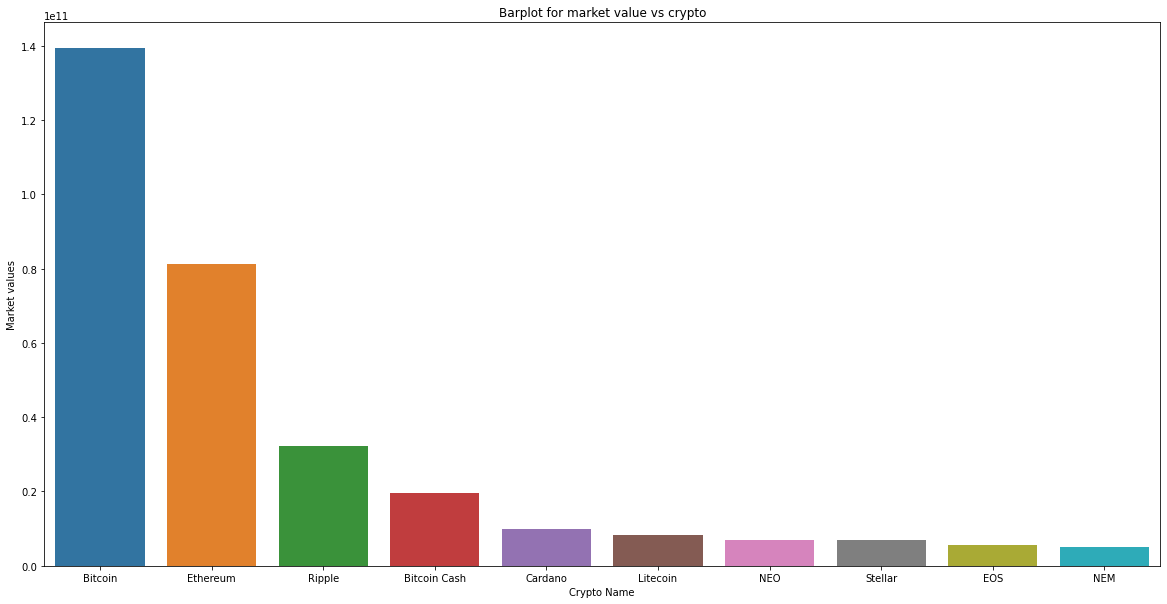

In [17]:
plt.figure(figsize=(20,10))
sns.barplot(x=latest_df['name'][:x], y=latest_df['market'][:x])
plt.xlabel('Crypto Name')
plt.ylabel('Market values')
plt.title('Barplot for market value vs crypto')

### Volume 
Volume is a measure of how much of a given financial asset has been traded in a given period of time and even though so simple, it can be a powerful indicator for trading.

Text(0.5, 1.0, 'Barplot for market value vs Volume')

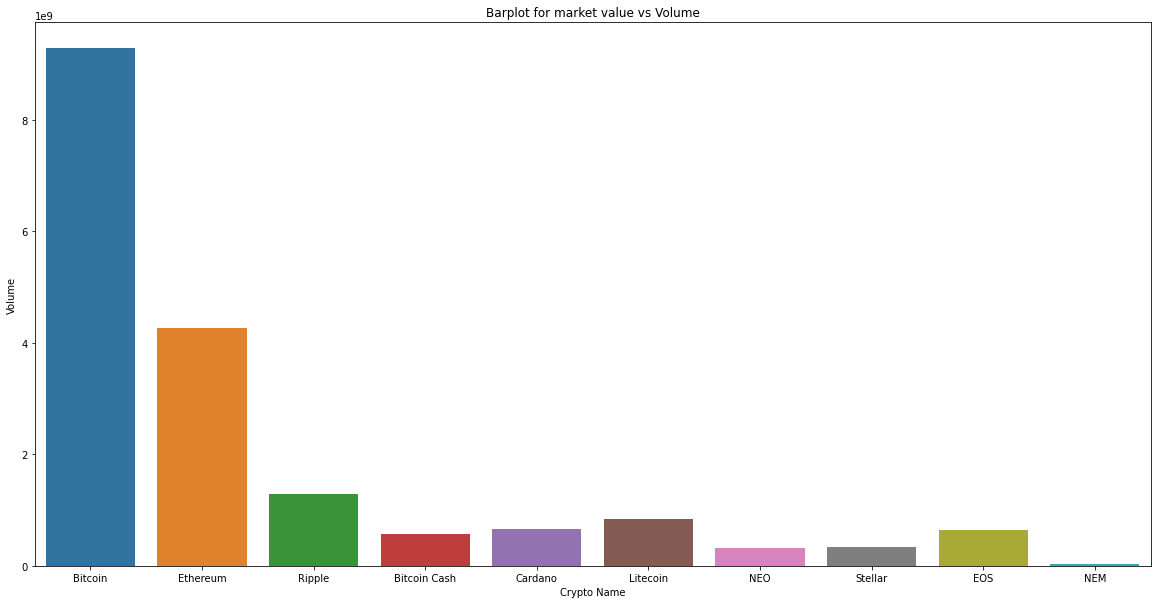

In [18]:
plt.figure(figsize=(20,10))
sns.barplot(x=latest_df['name'][:x], y=latest_df['volume'][:x])
plt.xlabel('Crypto Name')
plt.ylabel('Volume')
plt.title('Barplot for market value vs Volume')

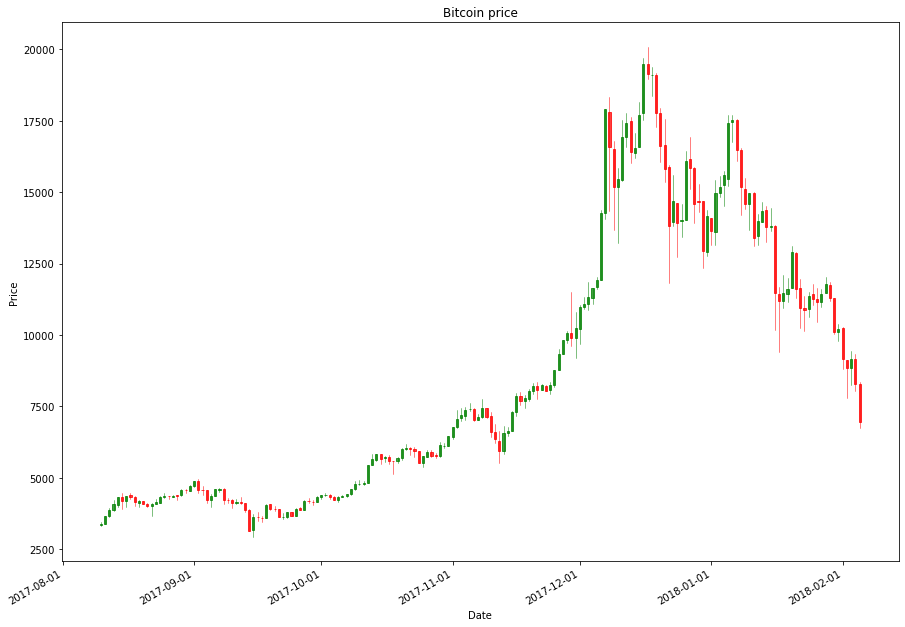

In [19]:
# Candlestick chart for Rank 1 currency (limited to 6 Months)
rank = 1
months = 6

name = df[df.ranknow == rank].iloc[-1]['name']
filtered_df = df[(df['ranknow'] == rank) & (df['date'] > (max(df['date']) - timedelta(days=30*months)))]
OHLCfiltered_df = filtered_df[['date','open','high','low','close']]
OHLCfiltered_df['date'] = mdates.date2num(OHLCfiltered_df['date'].dt.date)

f,ax=plt.subplots(figsize=(15,11))
ax.xaxis_date()
candlestick_ohlc(ax, OHLCfiltered_df.values, width=0.5, colorup='g', colordown='r',alpha=0.75)

plt.xlabel("Date")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.title(name + " price")
plt.ylabel("Price")
plt.show()

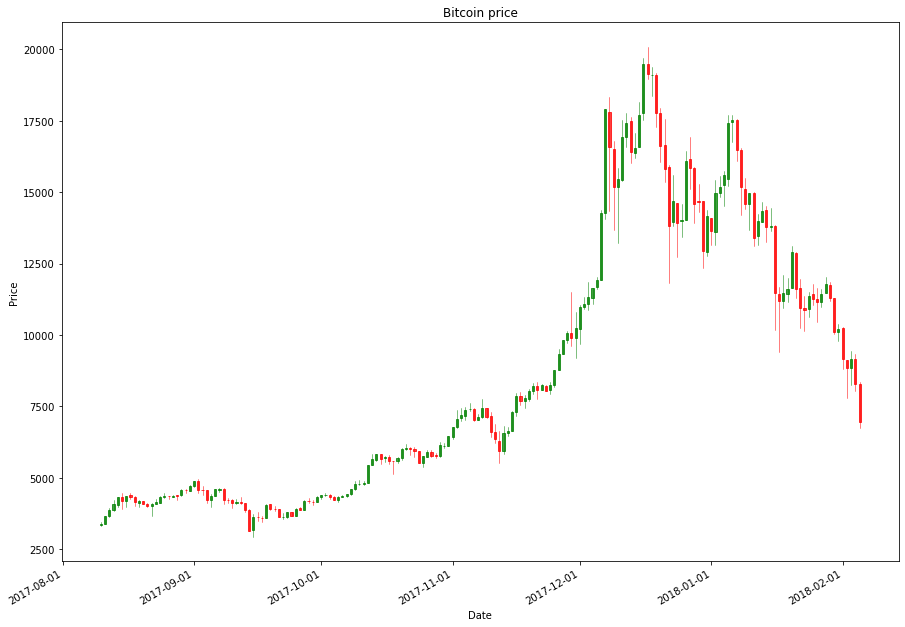

In [85]:
# Candlestick chart for Rank 1 currency (limited to 12 Months)
rank = 1
months = 6

name = df[df.ranknow == rank].iloc[-1]['name']
filtered_df = df[(df['ranknow'] == rank) & (df['date'] > (max(df['date']) - timedelta(days=30*months)))]
OHLCfiltered_df = filtered_df[['date','open','high','low','close']]
OHLCfiltered_df['date'] = mdates.date2num(OHLCfiltered_df['date'].dt.date)

f,ax=plt.subplots(figsize=(15,11))
ax.xaxis_date()
candlestick_ohlc(ax, OHLCfiltered_df.values, width=0.5, colorup='g', colordown='r',alpha=0.75)

plt.xlabel("Date")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.title(name + " price")
plt.ylabel("Price")
plt.show()

### Moving Averages 
Let’s now consider how we can find trends in stocks.

Moving averages are one of the oldest and simplest tradng "tools" which we can use.

A n-day moving average is, for a series and a point in time, the average of the past n days.

Moving averages smooth a series and helps identify trends. The larger n is, the less responsive a moving average process is to short-term fluctuations in the series. The idea is that moving average processes help identify trends from “noise”.

Exponentially Weighted Moving Average is a statistic for monitoring the process that averages the data in a way that gives less and less weight to data as they are further removed in time.

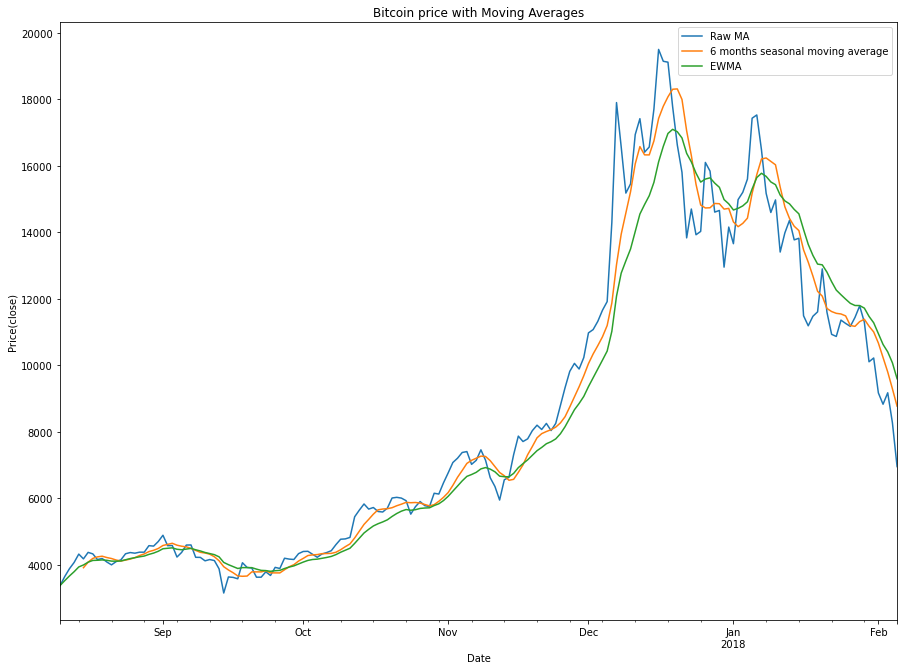

In [69]:
# Find moving average for bitcoin for over 6 months
rank = 1
months = 6

name = df[df.ranknow == rank].iloc[-1]['name']
filtered_df = df[(df['ranknow'] == rank) & (df['date'] > (max(df['date']) - timedelta(days=30*months)))]

filtered_df.set_index('date', inplace=True)

f, ax = plt.subplots(figsize=(15,11))
filtered_df.close.plot(ax=ax, label = 'Raw MA')
filtered_df.close.rolling(window=6).mean().plot(ax=ax, label="6 months seasonal moving average")
filtered_df.close.ewm(span=12).mean().plot(ax=ax, label="EWMA")



plt.title(name + " price with Moving Averages")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price(close)")
plt.show()

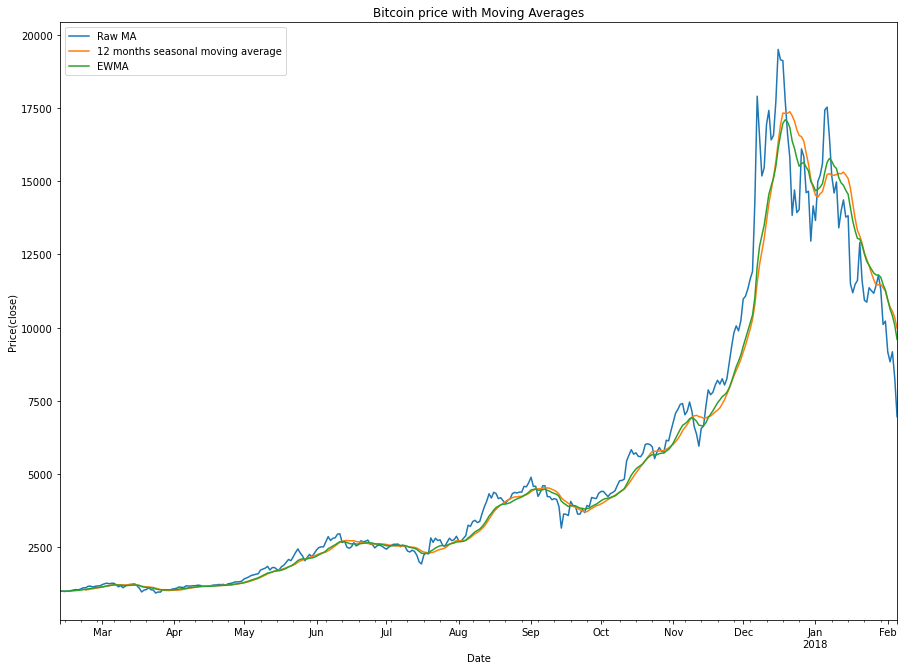

In [71]:
# Find moving average for bitcoin for over 6 months
rank = 1
months = 12

name = df[df.ranknow == rank].iloc[-1]['name']
filtered_df = df[(df['ranknow'] == rank) & (df['date'] > (max(df['date']) - timedelta(days=30*months)))]

filtered_df.set_index('date', inplace=True)

f, ax = plt.subplots(figsize=(15,11))
filtered_df.close.plot(ax=ax, label = 'Raw MA')
filtered_df.close.rolling(window=12).mean().plot(ax=ax, label="12 months seasonal moving average")
filtered_df.close.ewm(span=12).mean().plot(ax=ax, label="EWMA")



plt.title(name + " price with Moving Averages")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price(close)")
plt.show()

In [79]:
# Get the bitcoin data, rank 1, most information present
bitcoin_df = df[df['symbol'] == 'BTC']
bitcoin_df.drop(['slug', 'symbol','name', 'ranknow', 'volume','market', 'close_ratio', 'spread'], axis=1, inplace=True)

In [81]:
bitcoin_df.set_index('date')

,open,high,low,close
date,,,,
2013-04-28,135.30,135.98,132.10,134.21
2013-04-29,134.44,147.49,134.00,144.54
2013-04-30,144.00,146.93,134.05,139.00
2013-05-01,139.00,139.89,107.72,116.99
2013-05-02,116.38,125.60,92.28,105.21
...,...,...,...,...
2018-02-01,10237.30,10288.80,8812.28,9170.54
2018-02-02,9142.28,9142.28,7796.49,8830.75
2018-02-03,8852.12,9430.75,8251.63,9174.91


In [83]:
# Monthly forcasting
# Resampling to monthly frequency
btc_month = bitcoin_df.resample('M').mean()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'